In [37]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Feb 16 12:05:58 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Libraries

In [38]:
!pip install ipython-autotime
%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 3.25 s (started: 2022-02-16 12:05:59 +00:00)


In [39]:
!pip install --quiet optuna

time: 3.44 s (started: 2022-02-16 12:06:02 +00:00)


In [40]:
import os
import pandas as pd
import numpy as np
import time
import datetime
import itertools
import glob
import re
from tqdm import tqdm
import gc

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.style as style
style.use('fivethirtyeight')

from skimage import io
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

import tensorflow as tf
from keras import backend as K
import keras 
from keras.utils.layer_utils import count_params
from keras.preprocessing.image import ImageDataGenerator

from xgboost import XGBClassifier
import optuna # hyeperparam optimization 

time: 13.9 ms (started: 2022-02-16 12:06:06 +00:00)


# Variables

## Paths

In [41]:
root_dir ='/content/drive/MyDrive/@Projet datascientest/'
raw_data_dir = root_dir + 'RAW DATA/'
DL_dir = root_dir + 'DEEP LEARNING/' 
stacking_dir = '/content/drive/MyDrive/@Projet datascientest/DEEP LEARNING/Stacking/'
trained_model_dirs = '/content/drive/MyDrive/@Projet datascientest/DEEP LEARNING/Stacking/'

#ZIP file with images 
raw_data_folder = 'RAW DATA.zip'
# raw_data_folder = 'RAW DATA FOR DEBUG.zip' # pour aller plus vite sur unzip 1400 images only 
# df with file_path 
csv_file_paths = 'image_and_json_data_DEBUG.csv' if raw_data_folder == 'RAW DATA FOR DEBUG.zip' else 'image_and_json_data.csv'

# export dir with time satmp
timestamp = datetime.datetime.now().strftime('%y%m%d_%HH%M')
export_dir = DL_dir + timestamp + '/'
os.makedirs(export_dir)
print(str(export_dir))

/content/drive/MyDrive/@Projet datascientest/DEEP LEARNING/220216_12H06/
time: 9.12 ms (started: 2022-02-16 12:06:06 +00:00)


## Other

In [42]:
# seed
random_seed = 42


# resolution des images apres redimmensionnement (/!\ inversé par rapport à scikit)
resol = (240, 320) # (240, 320), [(24 , 32),(48 , 64),(72 , 96)]
# number of class to keep 
family_number = 7 # 7 pour comparaison Xgboost (acc = 0.32) & random 1/7 = 0.14
number_of_images = None  # None to get all images 
add_FRUIT360_images = False #add a class with 6000 images of 131 classes of fruit if true (kaggle dataset - 45 random images/class)

# DL Models 
redo_indivdual_predictions = False
batch_size = 512

# Optuna + XGBOOST
tree_method = 'gpu_hist' if int(os.environ["COLAB_GPU"]) > 0 else 'hist'
n_trials = 50 # number optuna bayesian opt 
n_estimators = 500 # nombre d'arbre xgboosting MAX qui sera limité par l'early stopping
early_stopping_rounds = 25  # window of the number of epochs over which no improvement is observed

# DEBUG 
debug = False
one_image_per_class_only = False  # HARD DEBUG TO SEE if CNN learn
# epochs
number_of_images = 1000 if debug else number_of_images
family_number = 3 if debug else family_number 


time: 8.71 ms (started: 2022-02-16 12:06:06 +00:00)


# Load & filter data

## Unzip images

In [43]:
# unzipping the file into the VM disk is SO much faster than reading each file individually from Drive
# cf https://stackoverflow.com/questions/59120853/google-colab-is-so-slow-while-reading-images-from-google-drive
main_path = "/content/"  + raw_data_folder.replace('.zip','') 
if os.path.exists(main_path)== False :
  if csv_file_paths == 'image_and_json_data_DEBUG.csv':
    !unzip '/content/drive/MyDrive/@Projet datascientest/RAW DATA FOR DEBUG.zip' -d "/content"
  elif csv_file_paths == 'image_and_json_data.csv':
    !unzip '/content/drive/MyDrive/@Projet datascientest/RAW DATA.zip' -d "/content"
else:
  print('ZIP already extracted')

ZIP already extracted
time: 4.8 ms (started: 2022-02-16 12:06:06 +00:00)


In [44]:
#FRUIT360 dataset pour créer un dataset sans champigons 
main_path = "/content/FRUIT360"
if os.path.exists(main_path)== False :
  if add_FRUIT360_images:
    !unzip '/content/drive/MyDrive/@Projet datascientest/FRUIT360.zip' -d "/content"

time: 3.22 ms (started: 2022-02-16 12:06:06 +00:00)


## File_path df

In [45]:
# df with path & target 
df_paths = pd.read_csv(root_dir + csv_file_paths)
print('{} rows in the file'.format(len(df_paths)))
df_paths .head()

215410 rows in the file


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (6,9,12) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,file_name,file_path,resolution,file_year,image_id,format,observation,label,image_url,user,date,thumbnail,location,gbif_info.kingdom,gbif_info.family,gbif_info.speciesKey,gbif_info.rank,gbif_info.phylum,gbif_info.orderKey,gbif_info.species,gbif_info.confidence,gbif_info.classKey,gbif_info.matchType,gbif_info.familyKey,gbif_info.status,gbif_info.usageKey,gbif_info.kingdomKey,gbif_info.genusKey,gbif_info.canonicalName,gbif_info.phylumKey,gbif_info.class,gbif_info.synonym,gbif_info.scientificName,gbif_info.genus,gbif_info.order,gbif_info.note,gbif_info,json_file
0,1208.jpg,C:/Users/thibe/Google Drive/Projet datasciente...,"(243, 320)",2006,1208,jpg,1007,Agaricales,http://mushroomobserver.org/images/320/1208,25,2006-11-20 05:11:15,1,25.0,Fungi,NaN,NaN,ORDER,Basidiomycota,1499.0,NaN,96.0,186.0,EXACT,NaN,ACCEPTED,1499.0,5.0,NaN,Agaricales,34.0,Agaricomycetes,False,Agaricales,NaN,Agaricales,NaN,NaN,observations_0.json
1,1604.jpg,C:/Users/thibe/Google Drive/Projet datasciente...,"(320, 164)",2006,1604,jpg,1535,Agaricales,http://mushroomobserver.org/images/320/1604,43,2006-12-16 00:59:32,1,9.0,Fungi,NaN,NaN,ORDER,Basidiomycota,1499.0,NaN,96.0,186.0,EXACT,NaN,ACCEPTED,1499.0,5.0,NaN,Agaricales,34.0,Agaricomycetes,False,Agaricales,NaN,Agaricales,NaN,NaN,observations_0.json
2,1608.jpg,C:/Users/thibe/Google Drive/Projet datasciente...,"(320, 286)",2006,1608,jpg,1537,Agaricales,http://mushroomobserver.org/images/320/1608,43,2006-12-16 01:25:12,1,55.0,Fungi,NaN,NaN,ORDER,Basidiomycota,1499.0,NaN,96.0,186.0,EXACT,NaN,ACCEPTED,1499.0,5.0,NaN,Agaricales,34.0,Agaricomycetes,False,Agaricales,NaN,Agaricales,NaN,NaN,observations_0.json
3,29.jpg,C:/Users/thibe/Google Drive/Projet datasciente...,"(240, 320)",2006,29,jpg,23,Agaricales,http://mushroomobserver.org/images/320/29,1,2006-05-21 07:17:47,1,61.0,Fungi,NaN,NaN,ORDER,Basidiomycota,1499.0,NaN,96.0,186.0,EXACT,NaN,ACCEPTED,1499.0,5.0,NaN,Agaricales,34.0,Agaricomycetes,False,Agaricales,NaN,Agaricales,NaN,NaN,observations_0.json
4,680.jpg,C:/Users/thibe/Google Drive/Projet datasciente...,"(240, 320)",2006,680,jpg,536,Agaricus,http://mushroomobserver.org/images/320/680,1,2006-05-21 07:34:55,1,1859.0,Fungi,Agaricaceae,NaN,GENUS,Basidiomycota,1499.0,NaN,92.0,186.0,EXACT,4170.0,ACCEPTED,7893259.0,5.0,7893259.0,Agaricus,34.0,Agaricomycetes,False,Agaricus,Agaricus,Agaricales,NaN,NaN,observations_0.json


time: 2.07 s (started: 2022-02-16 12:06:06 +00:00)


In [46]:
# FRUIT360
if add_FRUIT360_images:
  # Trouver tous les chemins vers les fichiers qui finissent par .jpg
  liste = glob.glob('/content/FRUIT360/*/*.jpg')
  # Remplacer les \\ par /
  liste = list(map(lambda x : [x, x.split('/')[2]], liste))
  # Créer un DataFrame pandas
  df_FRUIT360  = pd.DataFrame(liste, columns=['drive_file_path', 'gbif_info.family'])
  display(df_FRUIT360.head())

time: 3.67 ms (started: 2022-02-16 12:06:08 +00:00)


In [47]:
# adjust paths for drive 
# SPECIFIC DRIVE lo laod image from content 
df_paths['drive_file_path'] =df_paths['file_path'].apply(lambda x: x.replace('C:/Users/thibe/Google Drive/@Projet datascientest',
                                              '/content')).apply(lambda x: x.replace('C:/Users/thibe/Google Drive/Projet datascientest',
                                              '/content')) # pas propre, remplacer par regex + re à l'occas 
df_paths['drive_file_path'] =df_paths['drive_file_path'].apply(lambda x: x.replace('\\','/'))
df_paths['drive_file_path']

0         /content/RAW DATA/IMAGES/2006/Agaricales/1208.jpg
1         /content/RAW DATA/IMAGES/2006/Agaricales/1604.jpg
2         /content/RAW DATA/IMAGES/2006/Agaricales/1608.jpg
3           /content/RAW DATA/IMAGES/2006/Agaricales/29.jpg
4            /content/RAW DATA/IMAGES/2006/Agaricus/680.jpg
                                ...                        
215405    /content/RAW DATA/IMAGES/2016/Xylocoremium fla...
215406    /content/RAW DATA/IMAGES/2016/Xylocoremium fla...
215407    /content/RAW DATA/IMAGES/2016/Xylocoremium fla...
215408    /content/RAW DATA/IMAGES/2016/Xylocoremium fla...
215409    /content/RAW DATA/IMAGES/2016/Zygomycota/59276...
Name: drive_file_path, Length: 215410, dtype: object

time: 320 ms (started: 2022-02-16 12:06:08 +00:00)


In [48]:
#select only 320,240 images with family info
df_paths = df_paths[df_paths['resolution']=='(320, 240)'] 

time: 187 ms (started: 2022-02-16 12:06:08 +00:00)


In [49]:
# drop na 
df_paths = df_paths[df_paths['gbif_info.family'].notna()]

time: 65.9 ms (started: 2022-02-16 12:06:08 +00:00)


In [50]:
# keep conf level over 90 
df_paths = df_paths.loc[df_paths['gbif_info.confidence']>90]

time: 67.5 ms (started: 2022-02-16 12:06:08 +00:00)


In [51]:
# keep only most common class
top_class = df_paths['gbif_info.class'].value_counts().index[0]
df_paths = df_paths[df_paths['gbif_info.class'] == top_class]
df_paths['gbif_info.class'].value_counts()

Agaricomycetes    74497
Name: gbif_info.class, dtype: int64

time: 66.2 ms (started: 2022-02-16 12:06:09 +00:00)


In [52]:
# Check number of classes 
pd.DataFrame(df_paths.groupby(['gbif_info.family'], as_index=False).size())

,gbif_info.family,size
0,Agaricaceae,5254
1,Albatrellaceae,204
2,Amanitaceae,4769
3,Amylocorticiaceae,16
4,Amylostereaceae,6
...,...,...
99,Tubariaceae,217
100,Tulasnellaceae,37
101,Tulostomataceae,2
102,Typhulaceae,44


time: 27.2 ms (started: 2022-02-16 12:06:09 +00:00)


In [53]:
# keep only top families 
top_fam = df_paths['gbif_info.family'].value_counts().index[:family_number].values
df_paths = df_paths[df_paths['gbif_info.family'].isin(top_fam)]

time: 42.9 ms (started: 2022-02-16 12:06:09 +00:00)


In [54]:
# reduce number or images if needed 
if number_of_images != None and not one_image_per_class_only: 
  df_paths,_ = train_test_split(df_paths,train_size=number_of_images,stratify=df_paths['gbif_info.family'],random_state=random_seed )
  print('{} rows in the file'.format(len(df_paths)))

time: 2.47 ms (started: 2022-02-16 12:06:09 +00:00)


In [55]:
summary = df_paths.copy() #copy for later 
# summary.info()

time: 11 ms (started: 2022-02-16 12:06:09 +00:00)


In [56]:
# subset col of interest + label encoding
df = df_paths[['drive_file_path','gbif_info.family']].copy()
df['label'] = df['gbif_info.family'].replace(df['gbif_info.family'].unique(), [*range(len(df['gbif_info.family'].unique()))]).astype(str) # label encoding 

df.head()

,drive_file_path,gbif_info.family,label
5,/content/RAW DATA/IMAGES/2006/Agaricus/682.jpg,Agaricaceae,0
6,/content/RAW DATA/IMAGES/2006/Agaricus/685.jpg,Agaricaceae,0
7,/content/RAW DATA/IMAGES/2006/Agaricus albolut...,Agaricaceae,0
8,/content/RAW DATA/IMAGES/2006/Agaricus augustu...,Agaricaceae,0
9,/content/RAW DATA/IMAGES/2006/Agaricus augustu...,Agaricaceae,0


time: 64.4 ms (started: 2022-02-16 12:06:09 +00:00)


In [57]:
# concat with FRUIT360 
if add_FRUIT360_images:
  df_FRUIT360['label'] = df['label'].max() + 1 
  df = pd.concat([df,df_FRUIT360]).reset_index(drop=True)

time: 1.68 ms (started: 2022-02-16 12:06:09 +00:00)


In [58]:
# compute number of classes
print('number of rows = {}'.format(len(df['label'])))
dict_label_df = pd.DataFrame(df.groupby(['label','gbif_info.family'], as_index=False).size())
classes_count = len(dict_label_df)
dict_label_df

number of rows = 35787


,label,gbif_info.family,size
0,0,Agaricaceae,5254
1,1,Strophariaceae,4494
2,2,Amanitaceae,4769
3,3,Boletaceae,6060
4,4,Tricholomataceae,4967
5,5,Cortinariaceae,4124
6,6,Russulaceae,6119


time: 23.6 ms (started: 2022-02-16 12:06:09 +00:00)


In [59]:
# CREATE DICT LABELS 
dict_label = dict(dict_label_df[['label','gbif_info.family']].values)
dict_label

{'0': 'Agaricaceae',
 '1': 'Strophariaceae',
 '2': 'Amanitaceae',
 '3': 'Boletaceae',
 '4': 'Tricholomataceae',
 '5': 'Cortinariaceae',
 '6': 'Russulaceae'}

time: 5.02 ms (started: 2022-02-16 12:06:09 +00:00)


## Train/test split

In [60]:
#train/test 
# Train/test
df_train, df_test= train_test_split(df, train_size=0.8, stratify =df['label'], random_state=random_seed)
# train / val 
df_train_, df_val_= train_test_split(df_train, train_size=0.8, stratify =df_train['label'], random_state=random_seed)
print(df_train_.shape,df_val_.shape,df_test.shape)

(22903, 3) (5726, 3) (7158, 3)
time: 85.7 ms (started: 2022-02-16 12:06:09 +00:00)


In [61]:
# compute a class weigts dict for unbalanced loss computation
# { cf https://qastack.fr/datascience/13490/how-to-set-class-weights-for-imbalanced-classes-in-keras}
class_weights = class_weight.compute_class_weight(class_weight='balanced',classes =np.unique(df_train['label']),y =df_train['label'])
class_weights = dict(enumerate(class_weights))

time: 35.1 ms (started: 2022-02-16 12:06:09 +00:00)


### Plot few images

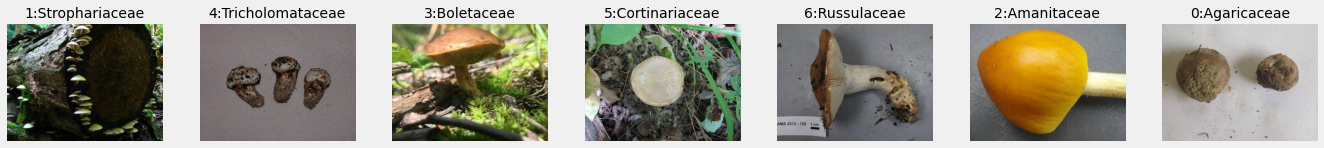

time: 734 ms (started: 2022-02-16 12:06:09 +00:00)


In [62]:
# first od each cat to check train/test
im_to_plot = df_train.groupby('label').head(1)
# plot
fig = plt.figure(figsize=(3*family_number,2))
j = 1 
for idx in im_to_plot.index:
  col_number = family_number
  row_number = 1
  ax = plt.subplot(row_number,col_number,j)
  im = io.imread(im_to_plot.loc[idx,'drive_file_path'])
  plt.imshow(im)
  label = str(im_to_plot.loc[idx,'label']) + ':' + dict_label[str(im_to_plot.loc[idx,'label'])]
  plt.title(label,size = 14)
  plt.axis('off')
  j +=1
fig.savefig(export_dir + str(resol) + '_first image of each family.jpeg' );

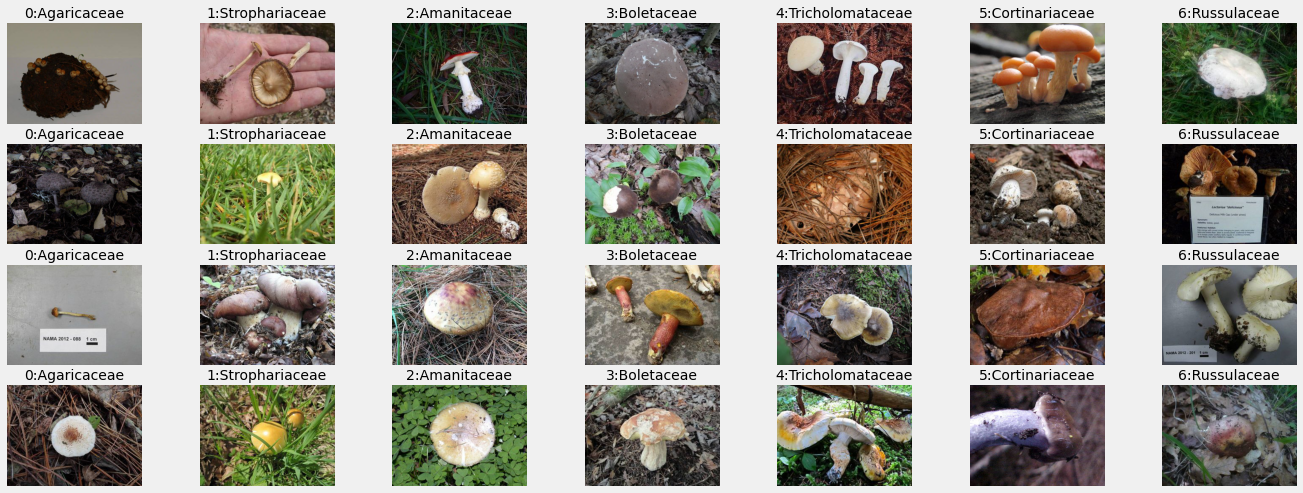

time: 1.79 s (started: 2022-02-16 12:06:10 +00:00)


In [63]:
# Plot random images de X_train (im_per_class per class)
im_per_class = 5 
#generate df with n image per class train set 
dfs_ = []
for n in range(im_per_class-1):
  df_ = df_train.groupby('label').apply(lambda x: x.sample(1))
  df_ = df_.droplevel(level=0)
  dfs_.append(df_)
im_to_plot = pd.concat(dfs_)
# plot
fig = plt.figure(figsize=(3*family_number,2*im_per_class))
j = 1 
for idx in im_to_plot.index:
  col_number = family_number
  row_number = im_per_class
  ax = plt.subplot(row_number,col_number,j)
  im = io.imread(im_to_plot.loc[idx,'drive_file_path'])
  plt.imshow(im)
  label = str(im_to_plot.loc[idx,'label']) + ':' + dict_label[str(im_to_plot.loc[idx,'label'])]
  plt.title(label,size = 14)
  plt.axis('off')
  j +=1
fig.savefig(export_dir + str(resol) + '_family examples.jpeg' );

# Fonctions

In [64]:
def conf_matrix(y_test_class , test_pred_class,classes,df_label):
  ## Première étape, la matrice de confusion
  cnf_matrix = np.around(confusion_matrix(y_test_class , test_pred_class,normalize='pred'),2)*100

  ### Display a nice confusion matrix
  classes = range(0,(classes))
  fig = plt.figure(figsize=(15,5))

  plt.imshow(cnf_matrix, interpolation='nearest',cmap='Blues')

  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes)
  plt.yticks(tick_marks, classes)
  plt.grid(False)

  for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
      plt.text(j, i, format(cnf_matrix[i, j],'.1f'),
              horizontalalignment = "center",
              color = "white" if cnf_matrix[i, j] > ( cnf_matrix.max() / 2) else "black")

  plt.ylabel('Vrais labels (%)')
  plt.xlabel('Labels prédits (%)')

  #add label dict 
  lab_dict = 'label, family, count  \n\n '
  lab_dict = lab_dict + str(df_label.values).replace("[","").replace("]","")
  lab_dict = re.sub(r'([0-9]+) ', r'\1, ', lab_dict)
  lab_dict = re.sub(r'([A-Za-z0-9]+\')', r'\1,', lab_dict)
  plt.text(len(classes)+2, (len(classes)+2)/2, lab_dict)
  #TILTLE 
  title =  pathinfos + '\n Test=' + str(len(y_test_class)) + ' images'
  plt.title(title, size=18,y=1.12,x=1)


  # plt.show()
  plt.close()
  return fig

time: 31.7 ms (started: 2022-02-16 12:06:12 +00:00)


In [65]:
def conf_matrix_and_clasif_report(y_test_class , test_pred_class,classes,df_label):
  ## Première étape, la matrice de confusion
  cnf_matrix = np.around(confusion_matrix(y_test_class , test_pred_class,normalize='pred'),2)*100

  ### Display a nice confusion matrix
  classes = range(0,(classes))
  fig = plt.figure(figsize=(20,5))

  plt.imshow(cnf_matrix, interpolation='nearest',cmap='Blues')

  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes)
  plt.yticks(tick_marks, classes)
  plt.grid(False)

  for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
      plt.text(j, i, format(cnf_matrix[i, j],'.1f'),
              horizontalalignment = "center",
              color = "white" if cnf_matrix[i, j] > ( cnf_matrix.max() / 2) else "black")

  plt.ylabel('Vrais labels (%)')
  plt.xlabel('Labels prédits (%)')
  #add classif report 
  # plt.axvline(x=len(classes)+2, color = 'black')
  rep = metrics.classification_report(y_test_class, test_pred_class)
  plt.text(len(classes)+2.5, len(classes)+1, '|\n'*20, va='bottom')
  plt.text(len(classes)+3, len(classes)-1, rep)
  #add label dict 
  lab_dict = 'label, family, count  \n\n '
  lab_dict = lab_dict + str(df_label.values).replace("[","").replace("]","")
  lab_dict = re.sub(r'([0-9]+) ', r'\1, ', lab_dict)
  lab_dict = re.sub(r'([A-Za-z0-9]+\')', r'\1,', lab_dict)
  plt.text(len(classes)+11.5, len(classes)+1, '|\n'*20, va='bottom')
  plt.text(len(classes)+12, (len(classes)+2)/2, lab_dict)



  #TILTLE 
  title =  pathinfos + '\n Test=' + str(len(y_test_class)) + ' images'
  plt.title(title, size=18,y=1.12,x=1.7,ha = 'center')


  # plt.show()
  plt.close()
  return fig

time: 40.2 ms (started: 2022-02-16 12:06:12 +00:00)


In [66]:
#cf https://stackoverflow.com/questions/62244457/progress-of-model-predict-in-tensorflow
class TQDMPredictCallback(keras.callbacks.Callback):
    def __init__(self, custom_tqdm_instance=None, tqdm_cls=tqdm, **tqdm_params):
        super().__init__()
        self.tqdm_cls = tqdm_cls
        self.tqdm_progress = None
        self.prev_predict_batch = None
        self.custom_tqdm_instance = custom_tqdm_instance
        self.tqdm_params = tqdm_params

    def on_predict_batch_begin(self, batch, logs=None):
        pass

    def on_predict_batch_end(self, batch, logs=None):
        self.tqdm_progress.update(batch - self.prev_predict_batch)
        self.prev_predict_batch = batch

    def on_predict_begin(self, logs=None):
        self.prev_predict_batch = 0
        if self.custom_tqdm_instance:
            self.tqdm_progress = self.custom_tqdm_instance
            return

        total = self.params.get('steps')
        if total:
            total -= 1

        self.tqdm_progress = self.tqdm_cls(total=total, **self.tqdm_params)

    def on_predict_end(self, logs=None):
        if self.tqdm_progress and not self.custom_tqdm_instance:
            self.tqdm_progress.close()

time: 16.9 ms (started: 2022-02-16 12:06:12 +00:00)


# Load individual models

In [67]:
if redo_indivdual_predictions:
  # get all zip files 
  os.chdir(trained_model_dirs)
  model_zips = glob.glob('*.zip')
  print(model_zips)

time: 1.99 ms (started: 2022-02-16 12:06:12 +00:00)


In [68]:
if redo_indivdual_predictions:
  #unzip models 
  for zip_file in model_zips:
    zip_path = trained_model_dirs + zip_file
    destination_dir = "/content/" + zip_file.replace(".zip","")
    if os.path.exists(destination_dir)== False :
      !unzip "$zip_path"  -d "$destination_dir"
    

time: 3.46 ms (started: 2022-02-16 12:06:12 +00:00)


In [69]:
models_dirs = [name for name in os.listdir("/content") if 'final_model' in name ]
models_dirs

['MobileNetV3Large_final_model', 'resnet50_final_model', 'EFB1_final_model']

time: 4.99 ms (started: 2022-02-16 12:06:12 +00:00)


## Individual predictions

In [70]:
# Load data 
# train sur df_train_ car on veut pas de biais
train_data_generator = ImageDataGenerator(
                                          # rotation_range=0.1,horizontal_flip= True,vertical_flip= True
                                          ) 
train_generator_ = train_data_generator.flow_from_dataframe(dataframe = df_train_, 
                                                          x_col = "drive_file_path",y_col="label",
                                                          shuffle = False, # to match label order  
                                                          target_size=resol,batch_size=batch_size,class_mode='sparse')
# val
val_data_generator = ImageDataGenerator() 
val_generator = val_data_generator.flow_from_dataframe(dataframe = df_val_, 
                                                          x_col = "drive_file_path",y_col="label", 
                                                          shuffle = False, # to match label order  
                                                          target_size=resol,batch_size=batch_size,class_mode='sparse')
#test 
test_generator = ImageDataGenerator().flow_from_dataframe(dataframe = df_test,
                                                        x_col = "drive_file_path",y_col="label", 
                                                        shuffle = False, # to match df_test order 
                                                          target_size=resol,batch_size=batch_size,class_mode='sparse')
# true label
y_train_class_= df_train_['label'].values.astype(int)
y_valid_class= df_val_['label'].values.astype(int)
y_test_class= df_test['label'].values.astype(int)

Found 22903 validated image filenames belonging to 7 classes.
Found 5726 validated image filenames belonging to 7 classes.
Found 7158 validated image filenames belonging to 7 classes.
time: 428 ms (started: 2022-02-16 12:06:12 +00:00)


In [71]:
# for dir_name in content_dirs:
#   print(dir_name)
#   name = dir_name.split("_")[0]
#   subdir_name = [name for name in os.listdir("/content/" +dir_name )][0] # pas toujours le meme nom 
#   models[name] = keras.models.load_model('/content/'+ dir_name + '/' + subdir_name)

time: 1.39 ms (started: 2022-02-16 12:06:12 +00:00)


**************************************************TEST set classification report**************************************************
**************************************************TEST set classification report**************************************************
**************************************************TEST set classification report**************************************************


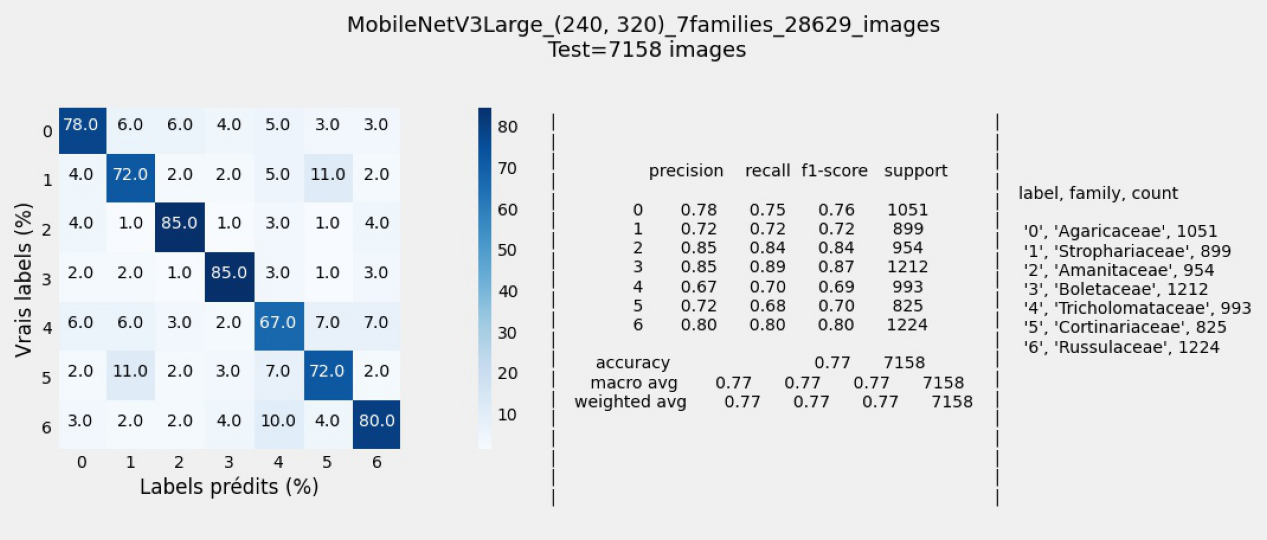

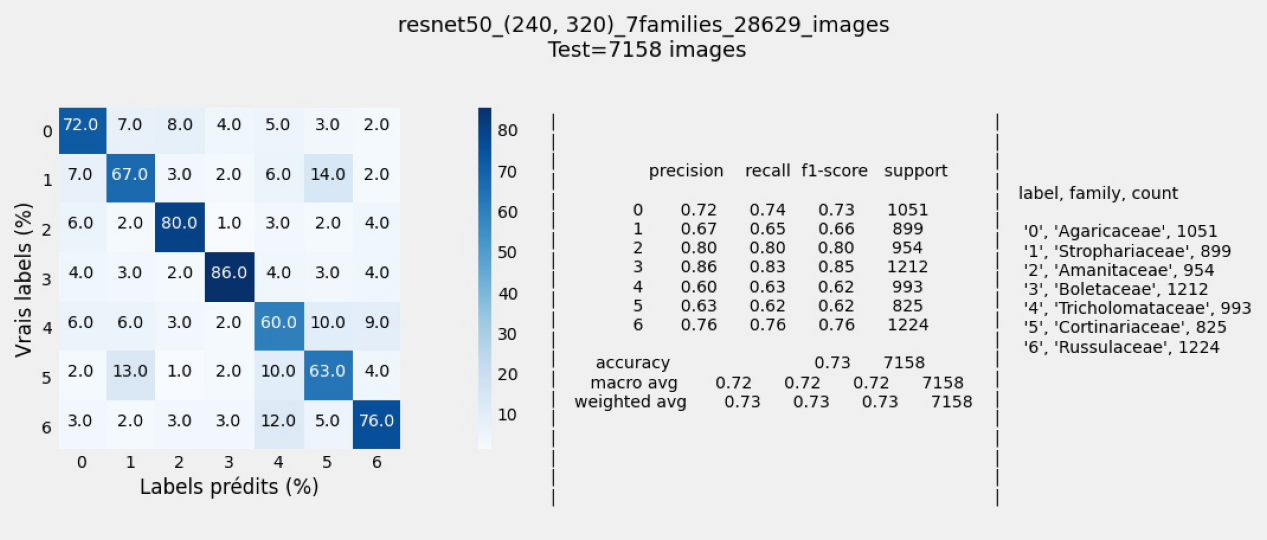

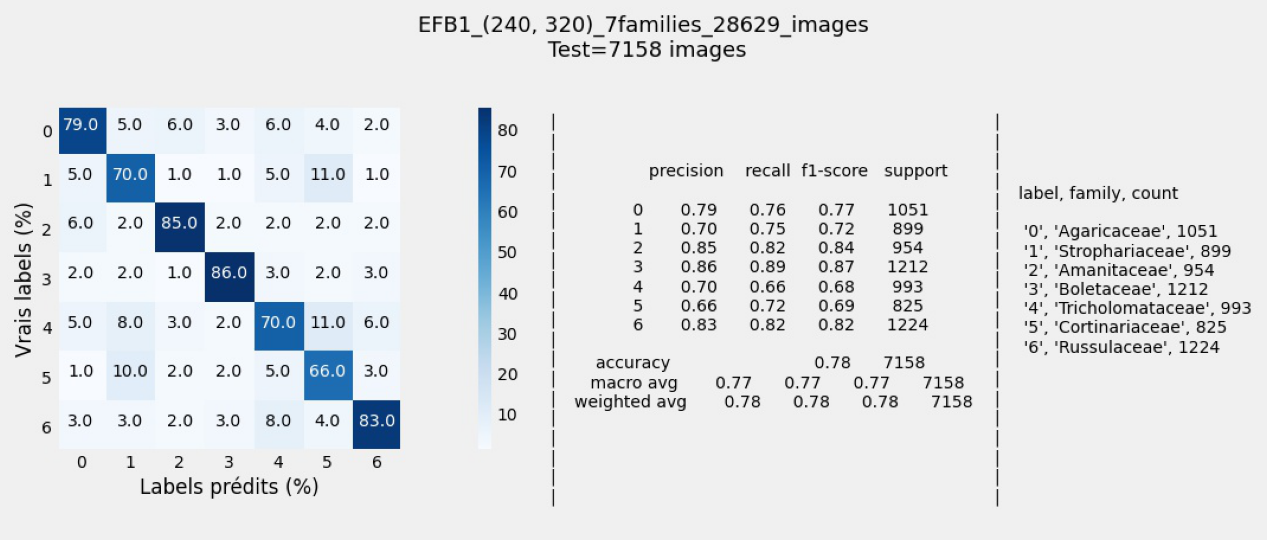

time: 1.33 s (started: 2022-02-16 12:06:12 +00:00)


In [72]:
# predict 
for model_dir in models_dirs:
  if redo_indivdual_predictions:
    predictions_test = {}
    predictions_val = {}
    predictions_train_ = {}
    # clear all models currently loaded in memory
    K.clear_session() 
    #load model 
    name = model_dir.split("_")[0]
    subdir_name = [name for name in os.listdir("/content/" +model_dir )][0] # pas toujours le meme nom
    model= keras.models.load_model('/content/'+ model_dir + '/' + subdir_name)
    # defnine pathinfos 
    pathinfos = name + '_' + str(resol) + '_' + str(family_number) + 'families_' + str(len(df_train)) + '_images'
    print("*"*50 + 'Predicting TRAIN with model ' + name +  '*'*50)
    y_prob_train_ = model.predict(train_generator_,len(df_train_)//batch_size,callbacks=[TQDMPredictCallback()]) 
    predictions_train_[name] = y_prob_train_
    print("*"*50 + 'Predicting VALID with model ' + name +  '*'*50)
    y_prob_val = model.predict(val_generator,len(df_val_)//batch_size,callbacks=[TQDMPredictCallback()]) 
    predictions_val[name] = y_prob_val
    print("*"*50 + 'Predicting TEST with model ' + name +  '*'*50)
    y_prob_test = model.predict(test_generator,len(df_test)//batch_size,callbacks=[TQDMPredictCallback()])
    predictions_test[name] = y_prob_test
    # predict classes 
    test_pred_class = np.argmax(y_prob_test , axis=1)
    print("*"*50 + 'TEST set classification report' + '*'*50)
    # report 
    print(metrics.classification_report(y_test_class, test_pred_class))
    # save report
    report = metrics.classification_report(y_test_class, test_pred_class, output_dict=True)
    report = pd.DataFrame(report).transpose()
    report_path = export_dir + pathinfos  + '_classification report.csv'
    report.to_csv(report_path)
    # conf matrix 
    classes = df['gbif_info.family'].nunique()  # classes
    # label and count for legend 
    unique, counts = np.unique(y_test_class, return_counts=True)
    test_dict_label = pd.DataFrame(zip(unique.astype(str), counts), columns=['label','y_test_count'])
    test_dict_label = dict_label_df.merge(test_dict_label,on='label')
    test_dict_label = test_dict_label.drop(['size'], axis=1)
    # plot 
    conf_matrix_fig = conf_matrix_and_clasif_report(y_test_class , test_pred_class,classes,test_dict_label)
    display(conf_matrix_fig)
    # save fig 
    conf_matrix_fig.savefig(export_dir + pathinfos +  '_conf_matrix.jpeg' ,bbox_inches = 'tight')
    del model
    gc.collect()
    K.clear_session()
  else: 
    # load images from folder
    print("*"*50 + 'TEST set classification report' + '*'*50)
    name = model_dir.split("_")[0]
    jpeg_files = glob.glob(stacking_dir + '/*.jpeg')
    conf_mat = [jpegfile for jpegfile  in jpeg_files if name in jpegfile and 'conf_matrix' in jpegfile][0]
    plt.figure(figsize=(20,10))
    im = io.imread(conf_mat)
    plt.axis('off')
    plt.imshow(im);

# Stacking

## Stack predictions

* https://machinelearningmastery.com/stacking-ensemble-for-deep-learning-neural-networks/

In [73]:
def stack_predictions(predict_dict):
  # Train 
  stackX = None 
  for model, prediction in predict_dict.items():
    # stack predictions into [rows, probabilities, models]
      if stackX is None:
        stackX = prediction
      else:
        stackX = np.dstack((stackX, prediction)) # ()
  # flatten predictions to [rows, probabilities x models ]
  stackX = stackX.reshape((stackX.shape[0], stackX.shape[1]*stackX.shape[2]))
  print(stackX.shape) 
  return stackX 

time: 4.6 ms (started: 2022-02-16 12:06:13 +00:00)


In [74]:
if redo_indivdual_predictions:
  stackX_train_ = stack_predictions(predictions_train_)
  stackX_val = stack_predictions(predictions_val)
  stackX_test = stack_predictions(predictions_test)
  # save predictions
  np.save( stacking_dir + 'stackX_train_', stackX_train_)
  np.save( stacking_dir + 'stackX_val', stackX_val)
  np.save( stacking_dir + 'stackX_test', stackX_test)

time: 2.99 ms (started: 2022-02-16 12:06:13 +00:00)


In [75]:
if redo_indivdual_predictions:
  #quick check 
  from sklearn.svm import SVC
  ML_mod = SVC(C=1)
  ML_mod.fit(stackX_train_, y_train_class_ )
  pred_ = ML_mod.predict(stackX_test).astype(int)
  print(metrics.classification_report(y_test_class, pred_ ))

time: 2.72 ms (started: 2022-02-16 12:06:13 +00:00)


## Hyperparam optimisation

In [76]:
# load predictions
stackX_train_ = np.load(stacking_dir + 'stackX_train_.npy')
stackX_val = np.load(stacking_dir + 'stackX_val.npy')
stackX_test = np.load(stacking_dir + 'stackX_test.npy')

time: 14.5 ms (started: 2022-02-16 12:06:14 +00:00)


In [77]:
def objective(trial):
  print('*'*50 + 'Trial' + str(trial.number) + '/' + str(n_trials) + ' started' + '*'*50)
   # trial param  
  params = {
      # 'gpu_hist' this parameter means using the GPU when training our model to speedup the training process
      'tree_method':tree_method, 
        # metric 
      "objective": "multi:softmax",
      # "eval_metric": "mlogloss",
      "num_class":7,
      # other 
      # "verbosity": 0,  # 0 (silent) - 3 (debug)
      "n_estimators": n_estimators, #  NOMBRE D'ARBRE MAX sera ajusté par early stopping 
      "max_depth": trial.suggest_int("max_depth", 5, 10), # 2, 25
      "learning_rate": trial.suggest_loguniform("learning_rate", 0.0005, 0.01),
      "colsample_bytree": trial.suggest_loguniform("colsample_bytree", 0.2, 0.6),
      "subsample": trial.suggest_loguniform("subsample", 0.1, 0.8), #0.4, 0.8
      "alpha": trial.suggest_loguniform("alpha", 1, 100.0), #  0.01, 10.0
      "lambda": trial.suggest_loguniform("lambda", 1e-9, 10), #1e-8, 10.0
      "gamma": trial.suggest_loguniform("gamma", 1e-8, 10.0), #  1e-8, 10.0
      "min_child_weight": trial.suggest_loguniform("min_child_weight", 1, 100),
      "seed": random_seed,
      "n_jobs": -1,
  }
  text = 'trial ' + str(trial.number) + ':' + str(trial.params)
  print(text)
  # ML model 
  xgb_model= XGBClassifier(**params) # Add a callback for pruning cf optuna 
  
  # Add a callback for pruning cf optuna 
  pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "validation_1-mlogloss") # pruning sur le set d'evaluation
  # ML model fit 
  xgb_model.fit(
                stackX_train_, y_train_class_ ,
                eval_set=[(stackX_train_,y_train_class_ ),(stackX_val, y_valid_class)],
                eval_metric="mlogloss",
                verbose=False,
                 callbacks=[pruning_callback],
                early_stopping_rounds=early_stopping_rounds, # DEF EARLY STOPPING 
                )
   # recupere le nombre de rounds pour future train avec le bon nombre via early stopping et pas celui donné par defaut
  n_estimators_early_stop = len(xgb_model.evals_result()['validation_1']['mlogloss']) # https://github.com/optuna/optuna/issues/1169 & https://xgboost.readthedocs.io/en/stable/python/python_api.html#module-xgboost.sklearn
  trial.set_user_attr('n_estimators', n_estimators_early_stop) # <=> epoch 
  print('n_estimators_early_stop = {}'.format(n_estimators_early_stop))
  # get resutlts 
  results = xgb_model.evals_result()
  val_loss = results['validation_1']['mlogloss'][-1]
  # predict on train et validation set 
  train_score = xgb_model.score(stackX_train_,y_train_class_ )
  val_score = xgb_model.score(stackX_val,y_valid_class)
  print('train/val acc={}/{}'.format(train_score,val_score))
  #add to df for later 
  trial.set_user_attr('train score',train_score) # accuracy on valid 
  trial.set_user_attr('valid score',val_score) # accuracy on valid 

  
  return val_loss # a voir si on prend pas l'accuracy plus tard 

study = optuna.create_study(direction='minimize',
                            pruner=optuna.pruners.HyperbandPruner(),
                            # pruner=optuna.pruners.MedianPruner( n_startup_trials=1 )
                            ) 
study.optimize(objective,n_trials=n_trials,callbacks= [lambda study, trial: gc.collect()])

[I 2022-02-16 12:06:14,075] A new study created in memory with name: no-name-e4e88cac-d217-4c51-a9e8-62191c28da02


**************************************************Trial0/50 started**************************************************
trial 0:{'max_depth': 5, 'learning_rate': 0.002471821578606016, 'colsample_bytree': 0.3413873632213441, 'subsample': 0.15782929394105863, 'alpha': 91.19732525348947, 'lambda': 3.9684036570562444e-05, 'gamma': 6.037922585055036e-07, 'min_child_weight': 4.042030879723517}


[I 2022-02-16 12:06:38,573] Trial 0 finished with value: 0.917151 and parameters: {'max_depth': 5, 'learning_rate': 0.002471821578606016, 'colsample_bytree': 0.3413873632213441, 'subsample': 0.15782929394105863, 'alpha': 91.19732525348947, 'lambda': 3.9684036570562444e-05, 'gamma': 6.037922585055036e-07, 'min_child_weight': 4.042030879723517}. Best is trial 0 with value: 0.917151.


n_estimators_early_stop = 500
train/val acc=0.9992140767585033/0.7916521131680055
**************************************************Trial1/50 started**************************************************
trial 1:{'max_depth': 10, 'learning_rate': 0.007779840518365832, 'colsample_bytree': 0.2543313737461188, 'subsample': 0.11018372830876587, 'alpha': 74.22490638912427, 'lambda': 0.26107713527090076, 'gamma': 1.0750427686227186, 'min_child_weight': 10.243508420505547}


[I 2022-02-16 12:06:52,630] Trial 1 finished with value: 0.675396 and parameters: {'max_depth': 10, 'learning_rate': 0.007779840518365832, 'colsample_bytree': 0.2543313737461188, 'subsample': 0.11018372830876587, 'alpha': 74.22490638912427, 'lambda': 0.26107713527090076, 'gamma': 1.0750427686227186, 'min_child_weight': 10.243508420505547}. Best is trial 1 with value: 0.675396.


n_estimators_early_stop = 500
train/val acc=0.9990830895515871/0.7911281872162068
**************************************************Trial2/50 started**************************************************
trial 2:{'max_depth': 5, 'learning_rate': 0.000610911364405378, 'colsample_bytree': 0.3133185015277336, 'subsample': 0.48794398394720184, 'alpha': 2.3088187851549153, 'lambda': 1.6283953866267696e-06, 'gamma': 0.003351717202268282, 'min_child_weight': 63.809550712208505}


[I 2022-02-16 12:07:01,478] Trial 2 finished with value: 1.501636 and parameters: {'max_depth': 5, 'learning_rate': 0.000610911364405378, 'colsample_bytree': 0.3133185015277336, 'subsample': 0.48794398394720184, 'alpha': 2.3088187851549153, 'lambda': 1.6283953866267696e-06, 'gamma': 0.003351717202268282, 'min_child_weight': 63.809550712208505}. Best is trial 1 with value: 0.675396.


n_estimators_early_stop = 500
train/val acc=0.998952102344671/0.7897310513447433
**************************************************Trial3/50 started**************************************************
trial 3:{'max_depth': 10, 'learning_rate': 0.003966095073941384, 'colsample_bytree': 0.251057968317347, 'subsample': 0.16033773683220032, 'alpha': 34.114463150775606, 'lambda': 0.0007186445273736624, 'gamma': 0.05352591636644513, 'min_child_weight': 33.62758088639685}


[I 2022-02-16 12:07:10,786] Trial 3 finished with value: 0.792786 and parameters: {'max_depth': 10, 'learning_rate': 0.003966095073941384, 'colsample_bytree': 0.251057968317347, 'subsample': 0.16033773683220032, 'alpha': 34.114463150775606, 'lambda': 0.0007186445273736624, 'gamma': 0.05352591636644513, 'min_child_weight': 33.62758088639685}. Best is trial 1 with value: 0.675396.


n_estimators_early_stop = 500
train/val acc=0.9989957647469764/0.7900803353126091
**************************************************Trial4/50 started**************************************************
trial 4:{'max_depth': 5, 'learning_rate': 0.0014003250569806331, 'colsample_bytree': 0.20197561290702715, 'subsample': 0.2066920924565813, 'alpha': 9.721153178685459, 'lambda': 0.0022089012277410193, 'gamma': 0.000984789683590999, 'min_child_weight': 9.733202144748992}


[I 2022-02-16 12:07:20,186] Trial 4 finished with value: 1.259467 and parameters: {'max_depth': 5, 'learning_rate': 0.0014003250569806331, 'colsample_bytree': 0.20197561290702715, 'subsample': 0.2066920924565813, 'alpha': 9.721153178685459, 'lambda': 0.0022089012277410193, 'gamma': 0.000984789683590999, 'min_child_weight': 9.733202144748992}. Best is trial 1 with value: 0.675396.


n_estimators_early_stop = 500
train/val acc=0.998952102344671/0.787635347537548


[I 2022-02-16 12:07:20,502] Trial 5 pruned. Trial was pruned at iteration 1.


**************************************************Trial5/50 started**************************************************
trial 5:{'max_depth': 9, 'learning_rate': 0.0006138619645314204, 'colsample_bytree': 0.4914988114126757, 'subsample': 0.18551434703874534, 'alpha': 36.828184298838565, 'lambda': 0.203242759178412, 'gamma': 2.4113209324822524e-07, 'min_child_weight': 14.59645160252719}
**************************************************Trial6/50 started**************************************************
trial 6:{'max_depth': 6, 'learning_rate': 0.0015455513417506482, 'colsample_bytree': 0.22258816356263825, 'subsample': 0.42650597664353895, 'alpha': 12.483271236041444, 'lambda': 0.006612277806416275, 'gamma': 0.8021892539248042, 'min_child_weight': 28.80607620212038}


[I 2022-02-16 12:07:30,594] Trial 6 finished with value: 1.207631 and parameters: {'max_depth': 6, 'learning_rate': 0.0015455513417506482, 'colsample_bytree': 0.22258816356263825, 'subsample': 0.42650597664353895, 'alpha': 12.483271236041444, 'lambda': 0.006612277806416275, 'gamma': 0.8021892539248042, 'min_child_weight': 28.80607620212038}. Best is trial 1 with value: 0.675396.


n_estimators_early_stop = 500
train/val acc=0.9989957647469764/0.7871114215857492


[I 2022-02-16 12:07:30,980] Trial 7 pruned. Trial was pruned at iteration 3.


**************************************************Trial7/50 started**************************************************
trial 7:{'max_depth': 8, 'learning_rate': 0.0028857541685125914, 'colsample_bytree': 0.20153667044470347, 'subsample': 0.2627466282762031, 'alpha': 8.915819611410532, 'lambda': 0.0008596425702953335, 'gamma': 0.8544544420866383, 'min_child_weight': 3.2942963573916373}
**************************************************Trial8/50 started**************************************************
trial 8:{'max_depth': 9, 'learning_rate': 0.0024493342897851326, 'colsample_bytree': 0.5471130044122575, 'subsample': 0.10670191385578143, 'alpha': 6.881793484740954, 'lambda': 0.00010711039745737358, 'gamma': 0.04359370284398451, 'min_child_weight': 21.336397079756324}


[I 2022-02-16 12:07:39,082] Trial 8 finished with value: 0.883586 and parameters: {'max_depth': 9, 'learning_rate': 0.0024493342897851326, 'colsample_bytree': 0.5471130044122575, 'subsample': 0.10670191385578143, 'alpha': 6.881793484740954, 'lambda': 0.00010711039745737358, 'gamma': 0.04359370284398451, 'min_child_weight': 21.336397079756324}. Best is trial 1 with value: 0.675396.


n_estimators_early_stop = 500
train/val acc=0.9993450639654193/0.7928746070555361
**************************************************Trial9/50 started**************************************************
trial 9:{'max_depth': 7, 'learning_rate': 0.0017130705254109495, 'colsample_bytree': 0.5137549206788384, 'subsample': 0.2868701657949163, 'alpha': 2.127106678743576, 'lambda': 9.515394872639069e-06, 'gamma': 1.4959662423775686e-06, 'min_child_weight': 3.720145277809009}


[I 2022-02-16 12:07:48,192] Trial 9 finished with value: 1.023341 and parameters: {'max_depth': 7, 'learning_rate': 0.0017130705254109495, 'colsample_bytree': 0.5137549206788384, 'subsample': 0.2868701657949163, 'alpha': 2.127106678743576, 'lambda': 9.515394872639069e-06, 'gamma': 1.4959662423775686e-06, 'min_child_weight': 3.720145277809009}. Best is trial 1 with value: 0.675396.


n_estimators_early_stop = 500
train/val acc=0.9993450639654193/0.7923506811037373


[I 2022-02-16 12:07:48,570] Trial 10 pruned. Trial was pruned at iteration 3.


**************************************************Trial10/50 started**************************************************
trial 10:{'max_depth': 9, 'learning_rate': 0.002701308548696753, 'colsample_bytree': 0.2997979805260185, 'subsample': 0.27524086175980295, 'alpha': 39.574286862452404, 'lambda': 4.440166666523191e-09, 'gamma': 0.03227276167513899, 'min_child_weight': 12.401494404400466}
**************************************************Trial11/50 started**************************************************
trial 11:{'max_depth': 6, 'learning_rate': 0.006844141494192526, 'colsample_bytree': 0.25492868139078567, 'subsample': 0.4411890202951849, 'alpha': 3.071120450369143, 'lambda': 0.0002886284835475232, 'gamma': 0.010806351927397371, 'min_child_weight': 2.208499378793131}


[I 2022-02-16 12:08:00,132] Trial 11 finished with value: 0.681045 and parameters: {'max_depth': 6, 'learning_rate': 0.006844141494192526, 'colsample_bytree': 0.25492868139078567, 'subsample': 0.4411890202951849, 'alpha': 3.071120450369143, 'lambda': 0.0002886284835475232, 'gamma': 0.010806351927397371, 'min_child_weight': 2.208499378793131}. Best is trial 1 with value: 0.675396.


n_estimators_early_stop = 500
train/val acc=0.9994760511723355/0.7888578414250786
**************************************************Trial12/50 started**************************************************
trial 12:{'max_depth': 10, 'learning_rate': 0.009985187546935928, 'colsample_bytree': 0.3093012994388839, 'subsample': 0.16567868107228462, 'alpha': 66.62853541860407, 'lambda': 4.3043654095351154e-08, 'gamma': 3.848854969726286, 'min_child_weight': 12.970025318074459}


[I 2022-02-16 12:08:08,343] Trial 12 finished with value: 0.676383 and parameters: {'max_depth': 10, 'learning_rate': 0.009985187546935928, 'colsample_bytree': 0.3093012994388839, 'subsample': 0.16567868107228462, 'alpha': 66.62853541860407, 'lambda': 4.3043654095351154e-08, 'gamma': 3.848854969726286, 'min_child_weight': 12.970025318074459}. Best is trial 1 with value: 0.675396.


n_estimators_early_stop = 377
train/val acc=0.9992140767585033/0.793398533007335


[I 2022-02-16 12:08:08,683] Trial 13 pruned. Trial was pruned at iteration 3.


**************************************************Trial13/50 started**************************************************
trial 13:{'max_depth': 10, 'learning_rate': 0.004836085046359261, 'colsample_bytree': 0.2150103471959971, 'subsample': 0.14532940852628556, 'alpha': 9.466724368275369, 'lambda': 0.00030564192053552015, 'gamma': 5.0898540783260654e-08, 'min_child_weight': 53.75850981296007}
**************************************************Trial14/50 started**************************************************
trial 14:{'max_depth': 5, 'learning_rate': 0.008184722556249803, 'colsample_bytree': 0.38514000679838656, 'subsample': 0.16913045646565328, 'alpha': 1.3960448543729518, 'lambda': 0.0005116974408650771, 'gamma': 0.01446297048056167, 'min_child_weight': 18.399786118056568}


[I 2022-02-16 12:08:15,724] Trial 14 finished with value: 0.678043 and parameters: {'max_depth': 5, 'learning_rate': 0.008184722556249803, 'colsample_bytree': 0.38514000679838656, 'subsample': 0.16913045646565328, 'alpha': 1.3960448543729518, 'lambda': 0.0005116974408650771, 'gamma': 0.01446297048056167, 'min_child_weight': 18.399786118056568}. Best is trial 1 with value: 0.675396.


n_estimators_early_stop = 426
train/val acc=0.999301401563114/0.7932238910234021
**************************************************Trial15/50 started**************************************************
trial 15:{'max_depth': 6, 'learning_rate': 0.007753719930306287, 'colsample_bytree': 0.22985588445650937, 'subsample': 0.2990481792203683, 'alpha': 16.221831844676988, 'lambda': 2.512708563673658e-07, 'gamma': 0.0017978398531982485, 'min_child_weight': 5.235016574047785}


[I 2022-02-16 12:08:16,233] Trial 15 pruned. Trial was pruned at iteration 9.
[I 2022-02-16 12:08:16,646] Trial 16 pruned. Trial was pruned at iteration 3.


**************************************************Trial16/50 started**************************************************
trial 16:{'max_depth': 10, 'learning_rate': 0.0007048268467462989, 'colsample_bytree': 0.37194121684211856, 'subsample': 0.6211081566691077, 'alpha': 2.648478120752177, 'lambda': 4.7634737124253746e-08, 'gamma': 0.11519327401639091, 'min_child_weight': 1.6588414823006523}


[I 2022-02-16 12:08:16,968] Trial 17 pruned. Trial was pruned at iteration 1.


**************************************************Trial17/50 started**************************************************
trial 17:{'max_depth': 7, 'learning_rate': 0.003054678932157139, 'colsample_bytree': 0.2835747086386876, 'subsample': 0.4911903541551131, 'alpha': 82.27997980469132, 'lambda': 7.992391683647309e-05, 'gamma': 1.6148389952218112, 'min_child_weight': 2.7133672441380847}


[I 2022-02-16 12:08:17,271] Trial 18 pruned. Trial was pruned at iteration 1.


**************************************************Trial18/50 started**************************************************
trial 18:{'max_depth': 5, 'learning_rate': 0.0005868115485897504, 'colsample_bytree': 0.4281924155699089, 'subsample': 0.14709377793004969, 'alpha': 25.940633907418963, 'lambda': 4.979902268552864, 'gamma': 0.1760960770967919, 'min_child_weight': 13.744236739707386}
**************************************************Trial19/50 started**************************************************
trial 19:{'max_depth': 9, 'learning_rate': 0.009533693143772079, 'colsample_bytree': 0.32018237293232343, 'subsample': 0.10511492267132669, 'alpha': 2.4181476374516238, 'lambda': 1.6743989652594206e-09, 'gamma': 0.023519293677260772, 'min_child_weight': 1.165775405994527}


[I 2022-02-16 12:08:18,199] Trial 19 pruned. Trial was pruned at iteration 27.


**************************************************Trial20/50 started**************************************************
trial 20:{'max_depth': 7, 'learning_rate': 0.0026668636017201444, 'colsample_bytree': 0.5193020656710694, 'subsample': 0.18931899899864543, 'alpha': 31.399071793314093, 'lambda': 3.233724523568494e-07, 'gamma': 0.0006711676255480093, 'min_child_weight': 1.5978059661489221}


[I 2022-02-16 12:08:19,035] Trial 20 pruned. Trial was pruned at iteration 27.
[I 2022-02-16 12:08:19,373] Trial 21 pruned. Trial was pruned at iteration 1.


**************************************************Trial21/50 started**************************************************
trial 21:{'max_depth': 10, 'learning_rate': 0.00354911428865892, 'colsample_bytree': 0.3764900962872461, 'subsample': 0.10047924901150039, 'alpha': 91.54836851669836, 'lambda': 1.443709731032867e-07, 'gamma': 2.2598976081654443e-05, 'min_child_weight': 95.30060507073969}


[I 2022-02-16 12:08:19,757] Trial 22 pruned. Trial was pruned at iteration 3.


**************************************************Trial22/50 started**************************************************
trial 22:{'max_depth': 8, 'learning_rate': 0.005040899210441725, 'colsample_bytree': 0.27384819934506793, 'subsample': 0.19936077518774198, 'alpha': 49.40617096569071, 'lambda': 2.085812171879346e-09, 'gamma': 9.416708009797948e-06, 'min_child_weight': 6.907901688595614}


[I 2022-02-16 12:08:20,091] Trial 23 pruned. Trial was pruned at iteration 1.


**************************************************Trial23/50 started**************************************************
trial 23:{'max_depth': 8, 'learning_rate': 0.0009906255698963634, 'colsample_bytree': 0.3569978835994294, 'subsample': 0.7124749186500353, 'alpha': 99.40984987916444, 'lambda': 3.5181606838529534e-07, 'gamma': 9.944450624475454, 'min_child_weight': 2.111358408221615}
**************************************************Trial24/50 started**************************************************
trial 24:{'max_depth': 5, 'learning_rate': 0.0029232169267257957, 'colsample_bytree': 0.24248879540583498, 'subsample': 0.1915816166601683, 'alpha': 29.529567565475244, 'lambda': 1.9292641377613393e-09, 'gamma': 3.1820453076603883e-06, 'min_child_weight': 1.5315344610580919}


[I 2022-02-16 12:08:20,554] Trial 24 pruned. Trial was pruned at iteration 9.
[I 2022-02-16 12:08:20,877] Trial 25 pruned. Trial was pruned at iteration 1.


**************************************************Trial25/50 started**************************************************
trial 25:{'max_depth': 6, 'learning_rate': 0.0025074787048955088, 'colsample_bytree': 0.29630012880715206, 'subsample': 0.15041900194001592, 'alpha': 4.579089317423597, 'lambda': 5.42444506580712e-06, 'gamma': 8.937935473603754e-05, 'min_child_weight': 17.941795538138813}


[I 2022-02-16 12:08:21,221] Trial 26 pruned. Trial was pruned at iteration 3.


**************************************************Trial26/50 started**************************************************
trial 26:{'max_depth': 9, 'learning_rate': 0.0057670765287224585, 'colsample_bytree': 0.5956522027926685, 'subsample': 0.23841767584048607, 'alpha': 48.28848481813265, 'lambda': 1.566696848265539e-08, 'gamma': 0.011420285202045298, 'min_child_weight': 33.792237912170116}


[I 2022-02-16 12:08:21,577] Trial 27 pruned. Trial was pruned at iteration 1.


**************************************************Trial27/50 started**************************************************
trial 27:{'max_depth': 10, 'learning_rate': 0.00382775230387535, 'colsample_bytree': 0.4021894553184232, 'subsample': 0.12464963463331477, 'alpha': 1.1377236553963141, 'lambda': 2.5236822090369224e-06, 'gamma': 7.324527644351692e-07, 'min_child_weight': 1.3856766367140685}
**************************************************Trial28/50 started**************************************************
trial 28:{'max_depth': 5, 'learning_rate': 0.00180332220348927, 'colsample_bytree': 0.3956761319521992, 'subsample': 0.6290545339679018, 'alpha': 44.14924012181296, 'lambda': 0.0005348880797762069, 'gamma': 1.187461637901598e-06, 'min_child_weight': 48.408503578484975}


[I 2022-02-16 12:08:22,054] Trial 28 pruned. Trial was pruned at iteration 9.
[I 2022-02-16 12:08:22,395] Trial 29 pruned. Trial was pruned at iteration 1.


**************************************************Trial29/50 started**************************************************
trial 29:{'max_depth': 7, 'learning_rate': 0.0009208188125550157, 'colsample_bytree': 0.33076672136296775, 'subsample': 0.3499804922367544, 'alpha': 21.020856893831652, 'lambda': 0.029893187144256445, 'gamma': 1.3939321901368739e-08, 'min_child_weight': 5.2258061384934775}
**************************************************Trial30/50 started**************************************************
trial 30:{'max_depth': 5, 'learning_rate': 0.003917229892967377, 'colsample_bytree': 0.2231095326116761, 'subsample': 0.5394951564719263, 'alpha': 3.353423706489045, 'lambda': 7.096664654316482e-09, 'gamma': 6.892238220771588e-07, 'min_child_weight': 1.7990983400393665}


[I 2022-02-16 12:08:23,236] Trial 30 pruned. Trial was pruned at iteration 27.


**************************************************Trial31/50 started**************************************************
trial 31:{'max_depth': 5, 'learning_rate': 0.004918144112277141, 'colsample_bytree': 0.4962074908627202, 'subsample': 0.12235950849460756, 'alpha': 4.5756623394786535, 'lambda': 0.003243962695189581, 'gamma': 2.8160837594066314e-08, 'min_child_weight': 3.325926474407702}


[I 2022-02-16 12:08:31,502] Trial 31 finished with value: 0.697404 and parameters: {'max_depth': 5, 'learning_rate': 0.004918144112277141, 'colsample_bytree': 0.4962074908627202, 'subsample': 0.12235950849460756, 'alpha': 4.5756623394786535, 'lambda': 0.003243962695189581, 'gamma': 2.8160837594066314e-08, 'min_child_weight': 3.325926474407702}. Best is trial 1 with value: 0.675396.


n_estimators_early_stop = 500
train/val acc=0.9993887263677248/0.7939224589591338
**************************************************Trial32/50 started**************************************************
trial 32:{'max_depth': 10, 'learning_rate': 0.0008208065379125684, 'colsample_bytree': 0.33245593012990887, 'subsample': 0.15211978102486798, 'alpha': 2.62377181772248, 'lambda': 4.681944362024017e-06, 'gamma': 1.2930601032426933e-06, 'min_child_weight': 2.0463461595088006}


[I 2022-02-16 12:08:31,880] Trial 32 pruned. Trial was pruned at iteration 3.


**************************************************Trial33/50 started**************************************************
trial 33:{'max_depth': 5, 'learning_rate': 0.009973549904362541, 'colsample_bytree': 0.27605084499438615, 'subsample': 0.17390881226955984, 'alpha': 51.34098863646953, 'lambda': 8.263542197112976e-05, 'gamma': 0.0001360457759154329, 'min_child_weight': 8.285363783428933}


[I 2022-02-16 12:08:32,350] Trial 33 pruned. Trial was pruned at iteration 9.
[I 2022-02-16 12:08:32,668] Trial 34 pruned. Trial was pruned at iteration 1.


**************************************************Trial34/50 started**************************************************
trial 34:{'max_depth': 8, 'learning_rate': 0.0020718464937537952, 'colsample_bytree': 0.424635709387539, 'subsample': 0.23945895041599122, 'alpha': 29.868807406098515, 'lambda': 2.9426562886001838e-08, 'gamma': 0.010857586182234563, 'min_child_weight': 24.79908412219416}


[I 2022-02-16 12:08:33,033] Trial 35 pruned. Trial was pruned at iteration 3.


**************************************************Trial35/50 started**************************************************
trial 35:{'max_depth': 6, 'learning_rate': 0.007232716575845963, 'colsample_bytree': 0.24766699164099942, 'subsample': 0.11630883032481198, 'alpha': 6.394743786308337, 'lambda': 0.0005846996925124001, 'gamma': 0.11328781810463286, 'min_child_weight': 2.710111265385904}
**************************************************Trial36/50 started**************************************************
trial 36:{'max_depth': 10, 'learning_rate': 0.005094731424218704, 'colsample_bytree': 0.5727713726760553, 'subsample': 0.2830966710764585, 'alpha': 16.80356951000412, 'lambda': 2.6761328111313443, 'gamma': 0.0003938623587878464, 'min_child_weight': 2.995113899151285}


[I 2022-02-16 12:08:41,829] Trial 36 finished with value: 0.698691 and parameters: {'max_depth': 10, 'learning_rate': 0.005094731424218704, 'colsample_bytree': 0.5727713726760553, 'subsample': 0.2830966710764585, 'alpha': 16.80356951000412, 'lambda': 2.6761328111313443, 'gamma': 0.0003938623587878464, 'min_child_weight': 2.995113899151285}. Best is trial 1 with value: 0.675396.


n_estimators_early_stop = 500
train/val acc=0.9994760511723355/0.7940971009430667


[I 2022-02-16 12:08:42,151] Trial 37 pruned. Trial was pruned at iteration 1.


**************************************************Trial37/50 started**************************************************
trial 37:{'max_depth': 7, 'learning_rate': 0.0017583561337553358, 'colsample_bytree': 0.4890771256245464, 'subsample': 0.28475430488174636, 'alpha': 2.1808996817566153, 'lambda': 9.108229676438177e-06, 'gamma': 1.917893122866628e-06, 'min_child_weight': 4.088149859978949}


[I 2022-02-16 12:08:42,497] Trial 38 pruned. Trial was pruned at iteration 1.


**************************************************Trial38/50 started**************************************************
trial 38:{'max_depth': 7, 'learning_rate': 0.0011650112645925307, 'colsample_bytree': 0.5974473778198227, 'subsample': 0.3630830527778259, 'alpha': 1.242680696421284, 'lambda': 1.94154997851729e-05, 'gamma': 5.286208589301204e-06, 'min_child_weight': 3.7307092291910915}


[I 2022-02-16 12:08:42,848] Trial 39 pruned. Trial was pruned at iteration 1.


**************************************************Trial39/50 started**************************************************
trial 39:{'max_depth': 9, 'learning_rate': 0.0022300037017563444, 'colsample_bytree': 0.4894347045248193, 'subsample': 0.23273729834949963, 'alpha': 2.9901908260099193, 'lambda': 1.529209918376997e-06, 'gamma': 8.126958584818919e-08, 'min_child_weight': 1.8636138651092697}


[I 2022-02-16 12:08:43,233] Trial 40 pruned. Trial was pruned at iteration 3.


**************************************************Trial40/50 started**************************************************
trial 40:{'max_depth': 8, 'learning_rate': 0.001386386708722529, 'colsample_bytree': 0.34172516381034485, 'subsample': 0.17509215002018103, 'alpha': 1.9945434353403493, 'lambda': 0.004722247891732806, 'gamma': 2.1130280832076487, 'min_child_weight': 2.6469370973983724}


[I 2022-02-16 12:08:43,564] Trial 41 pruned. Trial was pruned at iteration 1.


**************************************************Trial41/50 started**************************************************
trial 41:{'max_depth': 5, 'learning_rate': 0.0007788997888753284, 'colsample_bytree': 0.3113292468429758, 'subsample': 0.16537302204457863, 'alpha': 65.39009107179344, 'lambda': 3.812121204273259e-08, 'gamma': 8.268091373437985e-07, 'min_child_weight': 5.977501243699948}


[I 2022-02-16 12:08:43,892] Trial 42 pruned. Trial was pruned at iteration 1.


**************************************************Trial42/50 started**************************************************
trial 42:{'max_depth': 8, 'learning_rate': 0.002749546278402949, 'colsample_bytree': 0.3662746406508186, 'subsample': 0.5682347703035122, 'alpha': 5.536354320070085, 'lambda': 3.5372923710669294e-05, 'gamma': 4.307908472587851e-05, 'min_child_weight': 3.2166474098572624}


[I 2022-02-16 12:08:44,215] Trial 43 pruned. Trial was pruned at iteration 1.


**************************************************Trial43/50 started**************************************************
trial 43:{'max_depth': 6, 'learning_rate': 0.0012406657267883836, 'colsample_bytree': 0.25170074546899407, 'subsample': 0.32976368519097976, 'alpha': 67.50766669120792, 'lambda': 9.169321666708023e-07, 'gamma': 1.545182218615822e-08, 'min_child_weight': 10.3851707595446}
**************************************************Trial44/50 started**************************************************
trial 44:{'max_depth': 7, 'learning_rate': 0.0021242810959239754, 'colsample_bytree': 0.2685414045893068, 'subsample': 0.10251156466572267, 'alpha': 16.15942839254238, 'lambda': 2.5996187985602236e-06, 'gamma': 0.11195577623466967, 'min_child_weight': 1.2263020807131504}


[I 2022-02-16 12:08:55,030] Trial 44 finished with value: 1.024359 and parameters: {'max_depth': 7, 'learning_rate': 0.0021242810959239754, 'colsample_bytree': 0.2685414045893068, 'subsample': 0.10251156466572267, 'alpha': 16.15942839254238, 'lambda': 2.5996187985602236e-06, 'gamma': 0.11195577623466967, 'min_child_weight': 1.2263020807131504}. Best is trial 1 with value: 0.675396.


n_estimators_early_stop = 500
train/val acc=0.9991267519538926/0.7900803353126091
**************************************************Trial45/50 started**************************************************


[I 2022-02-16 12:08:55,347] Trial 45 pruned. Trial was pruned at iteration 1.


trial 45:{'max_depth': 7, 'learning_rate': 0.0017574679727051187, 'colsample_bytree': 0.5353539450318081, 'subsample': 0.2562430336969168, 'alpha': 3.708830334675552, 'lambda': 0.0005847467320517769, 'gamma': 0.0006299648399810349, 'min_child_weight': 1.7799902071313658}


[I 2022-02-16 12:08:55,721] Trial 46 pruned. Trial was pruned at iteration 3.


**************************************************Trial46/50 started**************************************************
trial 46:{'max_depth': 9, 'learning_rate': 0.00387797342403035, 'colsample_bytree': 0.34147709120397673, 'subsample': 0.13005432908851397, 'alpha': 37.83148964658679, 'lambda': 5.48329258703167e-09, 'gamma': 2.923847306216784e-06, 'min_child_weight': 4.276520277555582}


[I 2022-02-16 12:08:56,044] Trial 47 pruned. Trial was pruned at iteration 1.


**************************************************Trial47/50 started**************************************************
trial 47:{'max_depth': 5, 'learning_rate': 0.0013704944751177935, 'colsample_bytree': 0.402272970573911, 'subsample': 0.210942653772144, 'alpha': 8.78447950126964, 'lambda': 0.0037348606195881104, 'gamma': 2.222506710351071e-07, 'min_child_weight': 10.338020421271166}


[I 2022-02-16 12:08:56,422] Trial 48 pruned. Trial was pruned at iteration 3.


**************************************************Trial48/50 started**************************************************
trial 48:{'max_depth': 10, 'learning_rate': 0.006492430843280333, 'colsample_bytree': 0.3092645243148443, 'subsample': 0.4131041526290845, 'alpha': 18.92659614388748, 'lambda': 0.1117999546892113, 'gamma': 0.00017866078016989416, 'min_child_weight': 8.018531071079256}


[I 2022-02-16 12:08:56,754] Trial 49 pruned. Trial was pruned at iteration 1.


**************************************************Trial49/50 started**************************************************
trial 49:{'max_depth': 6, 'learning_rate': 0.0015781267342855738, 'colsample_bytree': 0.2053614828595375, 'subsample': 0.42277303648308157, 'alpha': 13.831265135251277, 'lambda': 0.011212853846781915, 'gamma': 6.588263023382343, 'min_child_weight': 23.896505406098694}
time: 2min 42s (started: 2022-02-16 12:06:14 +00:00)


## Best staking model 

In [78]:
#get XGB param 
XGB_best_param = {}
for k,v in study.best_params.items():
  if k != 'layer_number':
    XGB_best_param[k] = v 
# Get number of trees 
bst_study_nb = study.best_trial.number
n_estimators_early_stop = int(study.trials_dataframe().loc[bst_study_nb,'user_attrs_n_estimators'])
n_estimators_early_stop

500

time: 15.2 ms (started: 2022-02-16 12:08:56 +00:00)


In [79]:
best_mod= XGBClassifier(**XGB_best_param,
                         n_estimators = n_estimators_early_stop , # to set number of tree found using early stopping
                        verbosity = 2,
                        tree_method=tree_method,
                        n_jobs=-1) 
best_mod.get_params

<bound method XGBModel.get_params of XGBClassifier(alpha=74.22490638912427, colsample_bytree=0.2543313737461188,
              gamma=1.0750427686227186, lambda=0.26107713527090076,
              learning_rate=0.007779840518365832, max_depth=10,
              min_child_weight=10.243508420505547, n_estimators=500, n_jobs=-1,
              subsample=0.11018372830876587, tree_method='gpu_hist',
              verbosity=2)>

time: 8.41 ms (started: 2022-02-16 12:08:57 +00:00)


In [80]:
# fit 
best_mod.fit(stackX_train_, y_train_class_)

XGBClassifier(alpha=74.22490638912427, colsample_bytree=0.2543313737461188,
              gamma=1.0750427686227186, lambda=0.26107713527090076,
              learning_rate=0.007779840518365832, max_depth=10,
              min_child_weight=10.243508420505547, n_estimators=500, n_jobs=-1,
              objective='multi:softprob', subsample=0.11018372830876587,
              tree_method='gpu_hist', verbosity=2)

time: 9.02 s (started: 2022-02-16 12:08:57 +00:00)


In [81]:
# predict label with XGBoost 
stack_test_pred_class = best_mod.predict(stackX_test).astype(int)

time: 15.3 ms (started: 2022-02-16 12:09:06 +00:00)


**************************************************TEST set classification report**************************************************
              precision    recall  f1-score   support

           0       0.78      0.80      0.79      1051
           1       0.74      0.76      0.75       899
           2       0.89      0.84      0.86       954
           3       0.90      0.89      0.89      1212
           4       0.69      0.73      0.71       993
           5       0.74      0.70      0.72       825
           6       0.83      0.83      0.83      1224

    accuracy                           0.80      7158
   macro avg       0.80      0.79      0.79      7158
weighted avg       0.80      0.80      0.80      7158



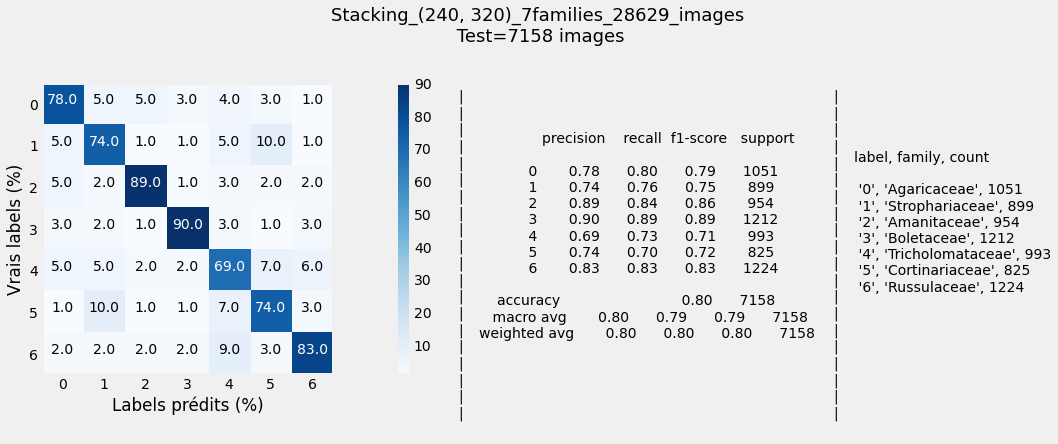

time: 1.01 s (started: 2022-02-16 12:09:06 +00:00)


In [82]:
#assess 
print("*"*50 + 'TEST set classification report' + '*'*50)
# report 
print(metrics.classification_report(y_test_class, stack_test_pred_class))
# save report
report = metrics.classification_report(y_test_class, stack_test_pred_class, output_dict=True)
report = pd.DataFrame(report).transpose()
report_path = export_dir + '_Stacking_classification report.csv'
report.to_csv(report_path)
# conf matrix 
classes = df['gbif_info.family'].nunique()  # classes
# label and count for legend 
unique, counts = np.unique(y_test_class, return_counts=True)
test_dict_label = pd.DataFrame(zip(unique.astype(str), counts), columns=['label','y_test_count'])
test_dict_label = dict_label_df.merge(test_dict_label,on='label')
test_dict_label = test_dict_label.drop(['size'], axis=1)
# plot 
pathinfos = 'Stacking' + '_' + str(resol) + '_' + str(family_number) + 'families_' + str(len(df_train)) + '_images'
conf_matrix_fig = conf_matrix_and_clasif_report(y_test_class , stack_test_pred_class,classes,test_dict_label)
display(conf_matrix_fig)
# save fig 
conf_matrix_fig.savefig(export_dir +  'Stacking_model_conf_matrix.jpeg' ,bbox_inches = 'tight')